In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
import pandas as pd
import numpy as np
import nltk.corpus
import nltk
%matplotlib inline

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

df = pd.read_csv('./archive/USvideos.csv')
categories = json.load(open('./archive/US_category_id.json', 'r'))

# Drop unused columns
df = df.drop(['thumbnail_link', 'video_id'], axis=1)
df = df.dropna()

# Enrich data
df['publish_hour'] = pd.to_datetime(df['publish_time']).dt.hour
df['comments_disabled'] = df['comments_disabled'].apply(lambda row: 0 if row == False else 1)
df['ratings_disabled'] = df['ratings_disabled'].apply(lambda row: 0 if row == False else 1)
df['video_error_or_removed'] = df['video_error_or_removed'].apply(lambda row: 0 if row == False else 1)
df['like_dislike'] = df[['likes', 'dislikes']].apply(lambda row: row['likes'] / np.sum([row['likes'], row['dislikes']]), axis=1)
df['tags'] = df['tags'].apply(lambda row: ' '.join( i.strip('""') for i in row.split('|') ))
df['anti_participation'] = df[['comments_disabled', 'ratings_disabled']].apply(lambda row: row.sum(), axis=1)

category_name_mapping = {}
for item in categories['items']:
    category_name_mapping[int(item['id'])] = item['snippet']['title']
df['category_name'] = df['category_id'].apply(lambda row: category_name_mapping[int(row)])

category_le = sk.preprocessing.LabelEncoder()
category_le.fit(df['category_id'])
df['category_id'] = category_le.transform(df['category_id'])

# Take out stop words
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))
df['tags'] = df['tags'].apply(lambda row: ' '.join(word for word in row.split() if word not in stop_words))
df['description'] = df['description'].apply(lambda row: ' '.join(word for word in row.split() if word not in stop_words))


df.head()

Num GPUs Available:  1


<ipython-input-1-2ad22ac217ab>:24: RuntimeWarning: invalid value encountered in long_scalars
  df['like_dislike'] = df[['likes', 'dislikes']].apply(lambda row: row['likes'] / np.sum([row['likes'], row['dislikes']]), axis=1)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,publish_hour,like_dislike,anti_participation,category_name
0,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,7,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,0,0,0,SHANTELL'S CHANNEL - https://www.youtube.com/s...,17,0.950970,0,People & Blogs
1,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,9,2017-11-13T07:30:00.000Z,last week tonight trump presidency last week t...,2418783,97185,6146,12703,0,0,0,"One year presidential election, John Oliver di...",7,0.940521,0,Entertainment
2,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,8,2017-11-12T19:05:24.000Z,racist superman rudy mancuso king bach racist ...,3191434,146033,5339,8181,0,0,0,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,19,0.964729,0,Comedy
3,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,9,2017-11-13T11:00:04.000Z,rhett link gmm good mythical morning rhett lin...,343168,10172,666,2146,0,0,0,Today find Link Nickelback amateur secret Nick...,11,0.938550,0,Entertainment
4,17.14.11,I Dare You: GOING BALD!?,nigahiga,9,2017-11-12T18:01:41.000Z,ryan higa higatv nigahiga dare idy rhpc dares ...,2095731,132235,1989,17518,0,0,0,"I know since show, we're back might best episo...",18,0.985181,0,Entertainment


In [2]:
def convert_to_sequences(x):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=False)
    tokenizer.fit_on_texts(x)
    _sequences = tokenizer.texts_to_sequences(x)
    maxlen = max(len(_seq) for _seq in _sequences)
    vocab_size = len(tokenizer.word_index) + 1
    _xtr = tf.keras.preprocessing.sequence.pad_sequences(_sequences, maxlen, padding='post')
    
    return np.array(_xtr), maxlen, vocab_size


#X, maxlen, vocab_size = convert_to_sequences(df['tags'].to_numpy())
X, maxlen, vocab_size = convert_to_sequences(df['description'].to_numpy())
#X, maxlen, vocab_size = convert_to_sequences(df['title'].to_numpy())

Y = tf.keras.utils.to_categorical(df['category_id'].to_numpy().reshape((-1,1)))

X.shape, Y.shape

((40379, 845), (40379, 16))

In [3]:
Xtr, Xts, ytr, yts = sk.model_selection.train_test_split(X, Y, shuffle=True, test_size=0.5)

In [4]:
Xtr.shape, ytr.shape

((20189, 845), (20189, 16))

In [5]:
activation = 'relu'

model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(maxlen,)))
model.add(tf.keras.layers.Embedding(vocab_size, 1028))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=32, activation=activation))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=24, activation=activation))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=16, activation=activation))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(len(category_le.classes_), activation='softmax'))

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['categorical_accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 845, 1028)         89170776  
_________________________________________________________________
dropout (Dropout)            (None, 845, 1028)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 814, 128)          4210816   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 791, 64)           196672    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 776, 32)           32800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 776, 32)           0         
_________________________________________________________________
dense (Dense)                (None, 776, 32)           1

In [6]:
history = model.fit(Xtr, ytr, epochs=10, batch_size=64)

Epoch 1/10
316/316 [==============================] - 225s 711ms/step - loss: 1.2687 - categorical_accuracy: 0.6122
Epoch 2/10
316/316 [==============================] - 228s 722ms/step - loss: 0.3312 - categorical_accuracy: 0.8997
Epoch 3/10
316/316 [==============================] - 228s 722ms/step - loss: 0.1677 - categorical_accuracy: 0.9479
Epoch 4/10
316/316 [==============================] - 227s 719ms/step - loss: 0.1898 - categorical_accuracy: 0.9504
Epoch 5/10
316/316 [==============================] - 228s 723ms/step - loss: 0.0808 - categorical_accuracy: 0.9767
Epoch 6/10
316/316 [==============================] - 228s 723ms/step - loss: 0.1224 - categorical_accuracy: 0.9741
Epoch 7/10
316/316 [==============================] - 228s 723ms/step - loss: 0.2272 - categorical_accuracy: 0.9564
Epoch 8/10
316/316 [==============================] - 227s 720ms/step - loss: 0.0750 - categorical_accuracy: 0.9807
Epoch 9/10
316/316 [==============================] - 228s 721ms/step - 

In [7]:
history.history

{'loss': [1.268738865852356,
  0.3312337398529053,
  0.16774344444274902,
  0.18980468809604645,
  0.080787792801857,
  0.12236066907644272,
  0.22720791399478912,
  0.07502175122499466,
  0.058848001062870026,
  0.053537338972091675],
 'categorical_accuracy': [0.6122145652770996,
  0.8996978402137756,
  0.947892427444458,
  0.9503690004348755,
  0.9766704440116882,
  0.974094808101654,
  0.9564118981361389,
  0.9806825518608093,
  0.9865273237228394,
  0.987617015838623]}

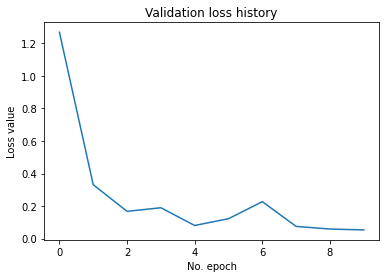

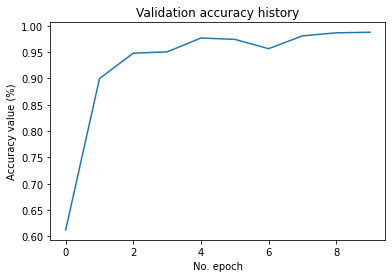

In [8]:
# Visualize history
# Plot history: Loss
plt.plot(history.history['loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

In [9]:
model.evaluate(Xts, yts)

631/631 [==============================] - 25s 39ms/step - loss: 0.2449 - categorical_accuracy: 0.9703


[0.2449110895395279, 0.9703318476676941]

In [10]:
model.save('model.h5')